# Optimising the timing of paid media spend

What is the best way of splitting a media budget across the year? [Two weeks ago](/anvil/paid-media-forecasting/) I wrote an introduction to forecasting paid media; in this post I will develop the ideas further to show you how to use a machine learning forecasting model to figure out how much you should spend on a channel across the year.

The big idea here is that if you have a forecast that uses daily spend as a regressor column (see the [last post](/anvil/paid-media-forecasting/) for more on this) then you can estimate what would happen in the future if you spent different amounts each day e.g. "what would happen if we spent 10% more on April 12th?"

This can be quite useful by itself but you can take things to another level by asking the computer to test lots of different spend levels on each day in order to find the optimal values. If you have a good forecast model then this process can find the perfect balance between the diminishing returns of increasing spend and the fact that at some times of year there is more demand and higher conversion rates. Very cool!

In this post I will walk you through how to do this. Unfortunately this isn't possible in the Forecast Forge Google Sheets addon because the addon hides a lot of the model details; I'm working on a solution for this at the moment but it is complicated. Instead I will build the forecast in tensorflow like I did with my most recent attempt to improve my [Mariah Carey predictions](/anvil/all-i-want-for-christmas-is-overfitting/).

For the training data I will use clicks and spend data from the [Google Analytics demo account](https://support.google.com/analytics/answer/6367342). This has the advantage of being public data from a real life Google Ads account. But it has some major disadvantages too as we shall see. If you can give me some data that I can anonymise and make public for use in future demos then I will give you a reduced rate for running the kind of analysis you see in this post; email [fergie@forecastforge.com](mailto:fergie@forecastforge.com) if you are interested in this.

Start by importing some libraries and loading the data

In [1]:
import pandas as pd
import tensorflow.compat.v2 as tf
tf.random.set_global_generator(1111)
tf.enable_v2_behavior()
import tensorflow_probability as tfp
import numpy as np
np.random.seed(1234)

raw = pd.read_csv("google-ads-sample.csv")
raw

2021-12-09 12:15:01.609375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nix/store/bz317974raly88wakps7h1y7p9l81hgz-gcc-10.3.0-lib/lib:
2021-12-09 12:15:01.609411: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Day   Clicks         Cost
0     2018-01-01      302      $122.93
1     2018-01-02      299      $134.97
2     2018-01-03      332      $134.61
3     2018-01-04      345      $128.13
4     2018-01-05      358      $129.13
...          ...      ...          ...
1419  2021-11-20      581      $807.64
1420  2021-11-21      474      $746.14
1421  2021-11-22      518      $727.00
1422  2021-11-23      295      $515.11
1423         NaN  249,269  $284,602.42

[1424 rows x 3 columns]

I exported far too much data from Google Analytics; in the early years the advertising spend is intermittent with long blocks of no spend at all. It has only been for the last 329 days when there has been consistent activity so we will take this data only for the model.

In the block below I'm also doing some other tidying up (removing the totals row, and converting everything to a number)

In [2]:
from datetime import date
# Remove totals row at the end
raw = raw.drop(1423).drop("Day", axis=1)

# Set data index
ix = pd.date_range(start=date(2018, 1, 1), end=date(2021, 11, 23), freq='D')
raw.index=ix

# Convert everything to a number
raw["Cost"] = raw['Cost'].str.replace('[$,]', '').astype("float")
raw["Clicks"] = raw["Clicks"].str.replace(',', '').astype("float")

# Take only the last 379 days of data
raw = raw[-379:]
raw

/run/user/1000/ipykernel_18908/1298462988.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  raw["Cost"] = raw['Cost'].str.replace('[$,]', '').astype("float")


Clicks    Cost
2020-11-10    39.0   24.93
2020-11-11   165.0  158.85
2020-11-12   107.0  164.09
2020-11-13   109.0  176.69
2020-11-14    97.0  330.31
...            ...     ...
2021-11-19   495.0  759.03
2021-11-20   581.0  807.64
2021-11-21   474.0  746.14
2021-11-22   518.0  727.00
2021-11-23   295.0  515.11

[379 rows x 2 columns]

Let's have a quick look at the data

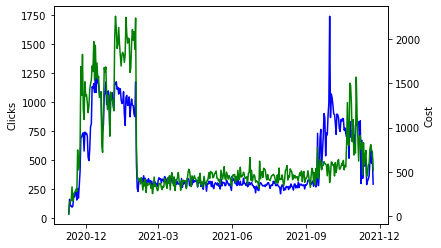

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data=raw["Clicks"], color="blue")
ax2 = ax.twinx()
sns.lineplot(data=raw["Cost"], ax=ax2, color="green")
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

It looks like they spent heavily in November through until February and then started up again in October. I have no idea why they would do it like this, but if you worked at Google on this account you would know and you might be able to include this information in the forecast model.

The main takeaway from me here is that there doesn't seem to be any trend or seasonality in the data; increases in clicks are mostly driven by an increase in spend. This means that a much simpler model without any seasonal components could work well here.

Let's also check the relationship between the daily cost and the number of clicks:

<AxesSubplot:xlabel='Cost', ylabel='Clicks'>

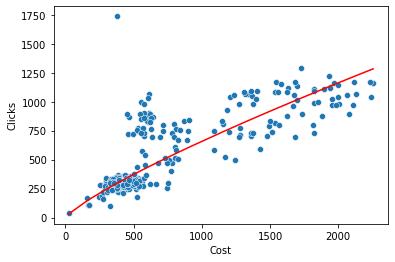

In [4]:
from scipy import stats

reg = stats.linregress(x=np.log(raw["Cost"]),y=np.log(raw["Clicks"]))

fig, ax = plt.subplots()
sns.scatterplot(x=raw["Cost"],y=raw["Clicks"], ax=ax)
sns.lineplot(x=raw["Cost"],y=np.exp(reg.intercept)*(raw["Cost"]**reg.slope),ax=ax, color="red")

This shows the expected diminishing returns curve; there are a lot of points on the right where spend has increased by a lot but the number of clicks has increased by proportionally less. There is also an outlier at the top with a very high number of clicks for a fairly low level of spend. I'm going to leave that there and not do anything with it for now but for a real life project this would be something to investigate further.

The red line on the above chart fits a power curve to the data `y=k*x^alpha`. The values of `k` and `alpha` are printed below. You can use these to optimise spend *but* using a forecasting model can work better because it allows for seasonal variation and trends in these values. I first read about this method of PPC forecasting in a [Search Engine Land post from 2007](https://searchengineland.com/free-tool-for-back-of-the-napkin-paid-search-forecasting-11554)

In [5]:
print("alpha: ", reg.slope)
print("k: ", reg.intercept)

alpha:  0.8214178170507559
k:  0.8148322151838423


I'd rather use as simple a model as possible for this demo so the model will use two components to predict the **log** of the number of clicks (see the [last post](https://www.forecastforge.com/anvil/paid-media-forecasting/) for more on why we use logs here):

+ A regression component that uses the **log** of the cost as input
+ A trend component that is meant to represent everything else that is going on. 

I don't think there is much structure in this timeseries so I am going to use a trend component called `LocalLevel` which is like a random walk. This means it can fit historical data quite well with few assumptions but the downside is that when you forecast into the future your best guess for the value of this component for all days is the last value you saw. i.e. the forecast is constant

In [6]:
def build_model(observed_time_series, cost_regressor):
  trend = tfp.sts.LocalLevel(observed_time_series=observed_time_series,  
                             name="Trend"
                            )
  cost = tfp.sts.LinearRegression(design_matrix=tf.reshape(cost_regressor,(-1,1)),   
                                  name="Cost"                       
                                 )
  model = tfp.sts.Sum([trend,cost], 
                      observed_time_series=observed_time_series, 
                      constant_offset=0 # forgetting this line cost me hours!
                     )
  return model

Now let's train the model on the observed data

2021-12-09 12:15:07.570924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nix/store/bz317974raly88wakps7h1y7p9l81hgz-gcc-10.3.0-lib/lib:
2021-12-09 12:15:07.570977: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 12:15:07.571034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (abulafia): /proc/driver/nvidia/version does not exist
2021-12-09 12:15:07.571459: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Do not call `graph_parents`.


2021-12-09 12:15:13.000277: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x95081b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-09 12:15:13.000336: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-12-09 12:15:13.189303: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
2021-12-09 12:15:13.196494: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-12-09 12:15:19.124977: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


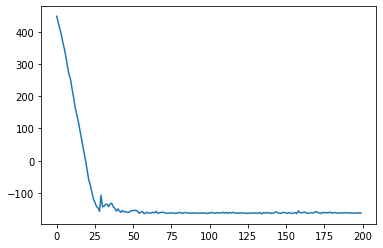

In [7]:
# Use a MaskedTimeSeries in case there are any missing values
# "Missing" here is most likely to be days with zero clicks
observed = tfp.sts.MaskedTimeSeries(
     time_series=np.log(raw["Clicks"]).astype("float32"),
     is_missing=np.isinf(np.log(raw["Clicks"]))
  )

# Setup the regressor as the log of the costs
regressor = np.log(raw["Cost"]).astype("float32")
# Rather than negative infinity on days with zero cost, change this to a low number
# I think this shouldn't be necessary because of using the MaskedTimeSeries above
# But best to be safe! I like the belt and braces approach
regressor[regressor == -np.inf] = -1e6

model = build_model(observed, regressor)


# Work the tensorflow magic
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

num_variational_steps = 200

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=observed),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples = variational_posteriors.sample(1000)

The loss converges (very quickly!) so we can proceed.

The variable `q_samples` contains samples from the model parameters

In [8]:
q_samples.keys()

odict_keys(['observation_noise_scale', 'Trend/_level_scale', 'Cost/_weights'])

+ `Trend/_level_scale` describes how quickly the `LocalLevel` random walk moves around
+ `Cost/_weights` are the regression coefficiants for the `LinearRegression` component on daily spend
+ `observation_noise_scale` is the amount random variation that isn't covered by the above two components

The `Cost/_weights` values are particularly interesting. Remember from last week, this determines how hard the account will be hit by diminishing returns on extra spend; values near 1 mean returns do not diminish very much and values near zero mean they diminish a lot. Values above 1 mean that there are increasing (not diminishing!) returns to extra spend.

Let's look at the distribution of these values

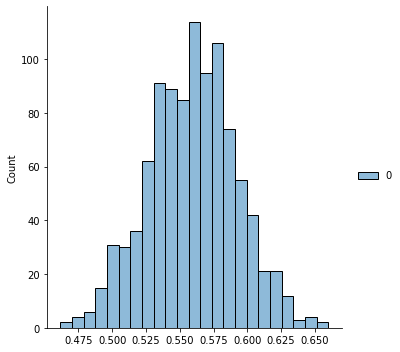

In [9]:
sns.displot(q_samples['Cost/_weights'].numpy())

In [10]:
q_samples['Cost/_weights'].numpy().mean()

0.55927974

This is about what I would expect; `0.5` is always a good starting point for a guess at this value and the actuals derived from the data are close to it.

We can also split the trained model back into the individual components. Let's do that to see how the `LocalLevel` trend changes over time

<AxesSubplot:>

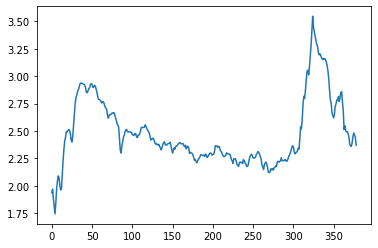

In [11]:
comps = tfp.sts.decompose_by_component(
    model, observed, q_samples
)
component_vals = {k.name: c.mean() for k, c in comps.items()}
sns.lineplot(data=component_vals['Trend/'].numpy())

The values on the y-axis here are added to the regressor component each day to give the estimate for the log of the number of clicks. Because of this, we can think of these values as being a *multiplier* on the actual number of clicks (because adding logs is like multiplying).

Lower values mean everything is multiplied by a smaller number - so you would expect to get fewer clicks for each dollar of ad spend. Higher values mean that everything is working more efficiently and you get more for each dollar of spend.

With a different model you can expect to see seasonal changes here with, for example, times of year with higher conversion rates getting high values and times of year with little demand getting low values.

I would need to do further analysis to figure out why Google were getting more efficient advertising around day 325 and why it dropped back again afterwards. It could be to do with them running brand adverts or turning off the display network or something like that.

The way it is correlated with an increase in spend and clicks makes me worry that there is something going on that the model isn't capturing but I will move on regardless so I can show you the good stuff.

To optimise the future spend, we need to add the future spend data to the `LinearRegression` component.

In [12]:
def build_cost_forecast_model(observed_time_series, cost_regressor, future_costs):
  regressor = np.concatenate([cost_regressor,future_costs])  
  trend = tfp.sts.LocalLevel(observed_time_series=observed_time_series, 
                             # Names must end with "/" for
                             # tfp.math.value_and_gradients to not throw a fit
                             name="Trend/"
                            )
  cost = tfp.sts.LinearRegression(design_matrix=tf.reshape(regressor,(-1,1)), 
                                  name="Cost/"                          
                                 )
  model = tfp.sts.Sum([trend,cost], 
                      observed_time_series=observed_time_series, 
                      constant_offset=0
                     )
  return model

# For this notebook, observed and regressor are fixed so we can make
# a function that only requires the future_costs as input
def build_forecast(future_costs):
    m1 = build_cost_forecast_model(observed, regressor, future_costs)
    forecast_dist = tfp.sts.forecast(
      m1,
      observed_time_series=observed,
      parameter_samples=q_samples,
      num_steps_forecast=future_costs.shape[0])
    return forecast_dist

Let's plot what the model predicts if the spend was to be the same for the next 12 months as it was for the last

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


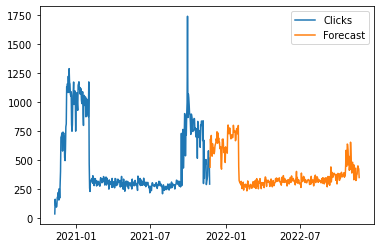

In [13]:
# Use the last 365 days as input
f = build_forecast(regressor[-365:].values)

# Reverse the log transform by taking the exponential
forecast_mean = np.exp(f.mean().numpy()[..., 0])

# Pad the forecast so the days line up with the observed data
padded_forecast = np.pad(forecast_mean,(observed[0].to_numpy().shape[0],0),constant_values=(np.NaN,))
forecast_df = raw[["Clicks"]]
ix = pd.date_range(start=date(2020, 11, 10), end=date(2022, 11, 23), freq='D')
forecast_df = forecast_df.reindex(ix)
forecast_df["Forecast"] = padded_forecast

# Plot
ax = sns.lineplot(data=forecast_df, dashes=False)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.show()

There are a couple of things to notice here:

1. The forecasted values are less "spikey" than the training data. This is because a large spike in the training data will be interpreted as partly being caused by random noise (i.e. higher values in the `observation_noise_scale` parameter)
2. The increase in spend at the end of the forecast period does not increase clicks as much as it did in training. This is because the model forecasts a much lower value for the trend than originally occured during this period in the training data.

You will also see point 1 occuring with most other machine learning forecasting methods. Point 2 is more unique to the trend component I picked for this example; you can get different (and better?) results by being cleverer with this.

Now we have a forecasting model we can use it to tell what is the optimal amount to spend each day. Basically, we will use machine learning to balance the diminishing returns we get from increasing spend with the fact that some days we expect to be able to spend more efficiently than others.

The forecasting model we have chosen for this example doesn't have a seasonal component; this means that the optimum amount to spend each day will be the same. Unfortunately this is kind of boring, but it does mean it is easy to verify if the machine learning optimiser has found the right result.

Suppose we want to optimise spend for the year. The process looks like this at a high level:

1. Make a function which takes 365 inputs (the spend for each day) and outputs the total return (revenue - costs) for the year
2. Give this function to an "optimiser" which is a special piece of software that will find the values of the 365 inputs that maximises the return

Searching all the possible values for 365 input variables is a lot so the optimiser will be more likely to find a solution if it also knows the *gradient* of the function at a point; you can think of this as telling the optimiser which direction is "uphill" so it knows where to go to find the point of maximum return.

It *should* be possible for the optimisers to work directly with the STS forecast object, but I get much better results by first decomposing the forecast and then using these values to make my own function.

In [14]:
# How many days to optimise
ndays = 365

f_model = build_cost_forecast_model(observed, 
                                    regressor, 
                                    # Dummy value here; not important because we only
                                    # want the other components
                                    np.repeat(1,ndays).astype("float32")
                                   )
forecast_dist = tfp.sts.forecast(
      f_model,
      observed_time_series=observed,
      parameter_samples=q_samples,
      num_steps_forecast=ndays)

decomp = tfp.sts.decompose_forecast_by_component(
    f_model,
    forecast_dist,
    q_samples
)

The variable `decomp` now contains the forecasted values for the other model components. For this example, we only need the trend; for a more complicated model we would need everything *except* the cost component.

In [15]:
means = {k.name: c.mean() for k,c in decomp.items()}
trend = means["Trend/"]
# Also store the alpha value in a variable
alpha = q_samples["Cost/_weights"].numpy().mean()

Next we can use these values to say what the return would be given a particular pattern of spend.

Remember that we are working with logs so the revenue we expect is

```
trend + alpha * log_costs
```

At this point working with logs can get a bit confusing; I certainly ended up face palming a few times.

The optimisers we are using don't know that things like daily spend can't be negative so we can't `log` transform the values on the way in and then `exp` them on the way out. Or at least not without moving towards doing some kind of "constraint optimisation" which is way more complicated (I hope to look at this is a few weeks because it is necessary for questions like "I have a budget of $X, how do I split it?").

But calculating things like "total spend" when all the daily spends are on a log scale gets complicated because doing this the naive way (`np.log(np.sum(np.exp(log_costs)))`) is *numerically unstable*. So in the code below you will see lots of weird tensorflow functions to avoid this.

In [16]:
def function_to_optimise(log_costs):
    log_revenue = trend + alpha * log_costs
    log_total_revenue = tf.math.reduce_logsumexp(log_revenue)
    log_total_spend = tf.math.reduce_logsumexp(log_costs)
    difference, sign = tfp.math.log_sub_exp([log_total_revenue], [log_total_spend], return_sign=True)
    total = tf.reduce_sum(sign*difference)
    return (-total)

Another interesting thing about the Google data is that their revenue per click is lower than their cost per click. This is one reason why I'm working with clicks rather than revenue or conversions here (the other is that the data for conversions is very sparse with lots of days with 0 conversions).

So in the above example we are effectively pretending that their revenue per click is `$1` (i.e. revenue number is the same as the clicks number). Their actual CPC is `$1.41` so in this case we would expect the optimiser to reduce spend down to a level where the forecasted CPC is lower than that.

To make things a bit more interesting (and perhaps realistic) I'm going to fudge things by adding an extra `1` to the `log_revenue` variable. This is the same as saying they have a revenue per click of `exp(1)=$2.72`.

So the actual `function_to_optimise` looks like this:

In [17]:
def function_to_optimise(log_costs):
    # Add 1 here
    log_revenue = 1 + trend + alpha * log_costs
    log_total_revenue = tf.math.reduce_logsumexp(log_revenue)
    log_total_spend = tf.math.reduce_logsumexp(log_costs)
    difference, sign = tfp.math.log_sub_exp([log_total_revenue], [log_total_spend], return_sign=True)
    total = tf.reduce_sum(sign*difference)
    return (-total)

One of the nice things about tensorflow is that it will calculate the gradients of this function automatically.

I am going to show you two different optimisers here. The first is slightly easier to use, but I find it doesn't always work as reliably; particularly if the optimal daily spends are a long way away from what they were last year.

In [18]:
# This optimiser needs a function that returns a (value, gradient) tuple
def vals_and_grads(x):
    return(tfp.math.value_and_gradient(function_to_optimise,x))

# Use the spend values for the last ndays as a starting point
# Different starting points might give better results!
start = raw["Cost"][-ndays:].to_numpy(dtype="float32")

# Set a seed so the results are the same
tf.random.set_seed(1234)

optim_results = tfp.optimizer.bfgs_minimize(
      vals_and_grads,
      # log transform the cost values to start
      initial_position=tf.constant(np.log(start)),
      max_iterations=1000
      )

If the optimiser has converged successfully then we should see `True` and `False` below:

In [19]:
{"converged":optim_results.converged.numpy(), "failed":optim_results.failed.numpy()}

{'converged': True, 'failed': False}

The algorithm claims to have converged. We can check the results by looking at the suggested daily spend values:

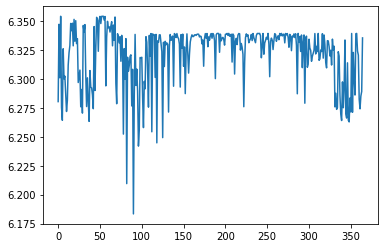

In [20]:
from matplotlib.ticker import ScalarFormatter
ax = sns.lineplot(data=optim_results.position.numpy())
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

These are all quite close together as our outside knowledge of the forecasting model says they should be. But remember that the numbers on the y-axis are on a log scale; `exp(6.175)=$481` and `exp(6.350)=$572` so `bfgs_minimize` is still suggesting a fairly large change in daily spend when we know that the recommendation should be fore the same spend each day.

An alternative optimiser which can work better for functions with a large number of variables (is 365 a large number?) is the Adam optimiser; this is commonly used for training large neural networks (365 is definitely not a large number in this context!). It is slightly harder to setup but should work for a wider variety of forecasts and starting points.

In [21]:
# Default learning rate is too low
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Use the same start point but set it up as a tf variable
log_costs = tf.Variable(np.log(start))

# loss (to be minimised) needs to be a function of this variable
loss = lambda: function_to_optimise(log_costs)

# initialising some global vars for stopping rules
step_count=0
delta_return=10
total_return=0

# Set the seed so the results are always the same
tf.random.set_seed(1234)

# Record the starting point on the first loop
# Useful for seeing how/if the optimiser has
# improved the expected outcome
start_revenue = None

# while loop keeps optimising until the return is 
# changing by only a tiny amount
while (delta_return>1e-12):
    old_return = total_return
    opt.minimize(loss, log_costs)
    log_revenue = 1 + trend + alpha * log_costs
    log_total_revenue = tf.math.reduce_logsumexp(log_revenue).numpy()
    log_total_cost = tf.math.reduce_logsumexp(log_costs).numpy()
    total_return = np.exp(log_total_revenue)-np.exp(log_total_cost)
    delta_return = abs(old_return-total_return)
    if start_revenue is None:
        start_revenue = np.exp(log_total_revenue)
        start_cost = np.exp(log_total_cost)
        start_return = total_return
    # Print out progress every 100 steps
    if(step_count % 10 == 0):
        print("Revenue:", np.exp(log_total_revenue),
            ", Costs:", np.exp(log_total_cost),
            ", Return:", total_return,
            ", Steps:", step_count    
            )
    step_count = step_count+1

# Print final result
print("Revenue:", np.exp(log_total_revenue),
      ", Costs:", np.exp(log_total_cost),
      ", Return:", total_return,
      ", Steps:", step_count
     )

Revenue: 397621.25 , Costs: 252977.84 , Return: 144643.4 , Steps: 0
Revenue: 373285.6 , Costs: 213013.28 , Return: 160272.31 , Steps: 10
Revenue: 355179.44 , Costs: 194678.69 , Return: 160500.75 , Steps: 20
Revenue: 357978.12 , Costs: 197362.34 , Return: 160615.78 , Steps: 30
Revenue: 362601.5 , Costs: 201724.2 , Return: 160877.3 , Steps: 40
Revenue: 365516.2 , Costs: 204526.06 , Return: 160990.12 , Steps: 50
Revenue: 366064.22 , Costs: 205054.17 , Return: 161010.05 , Steps: 60
Revenue: 365675.53 , Costs: 204659.92 , Return: 161015.61 , Steps: 70
Revenue: 365441.25 , Costs: 204421.55 , Return: 161019.7 , Steps: 80
Revenue: 365259.72 , Costs: 204238.78 , Return: 161020.94 , Steps: 90
Revenue: 365285.12 , Costs: 204263.5 , Return: 161021.62 , Steps: 100


In [22]:
from IPython.display import Markdown as md
md(f"""
At the optimum point, revenue (based on our `$2.72` RPC estimate) is down by 
`${start_revenue-np.exp(log_total_revenue):,.0f}` 
but because the optimiser suggests saving 
`${start_cost-np.exp(log_total_cost):,.0f}`
in media spend this works out as an overall predicted gain of 
`${total_return-start_return:,.0f}`
.

Plot the (log) of the daily spend to see how well the optimiser has worked:
""")


At the optimum point, revenue (based on our `$2.72` RPC estimate) is down by 
`$32,336` 
but because the optimiser suggests saving 
`$48,714`
in media spend this works out as an overall predicted gain of 
`$16,378`
.

Plot the (log) of the daily spend to see how well the optimiser has worked:


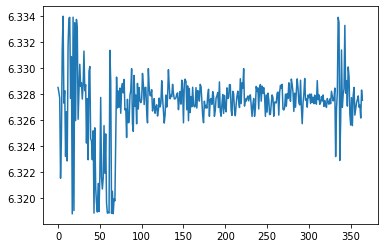

In [23]:
ax = sns.lineplot(data=log_costs.numpy())
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

In this case `Adam` has worked better than `bfgs_minimise` with daily spend recommendations between `exp(6.334)=$563` and `exp(6.320)=$556`.

This kind of difference between the two different optimisation algorithms is quite common in my experience. Sometimes `bfgs_minimise` absolutely nails it with a perfect solution but other times it can be quite far off. `Adam` struggles to match `bfgs_minimise` at it's best but is also more reliable and generally finds itself in roughly the right area.

In summary, **if** you have a good forecasting model then you can use it to optimise your daily spend across the year. However, it is *very* important that your forecasting model is good otherwise the optimiser will make recommendations based on false assumptions. For example, this image compares the "optimised" spend with the spend for the previous 12 months for a client:

![](https://www.forecastforge.com/files/too-smooth-forecast.png)

This has the problem where the forecast is too "smooth" so it misses out two important features:

1. Demand drops off steeply in December
2. It rises again *very* rapidly in the New Year

In both these cases the forecasting algorithm has not learned how quickly things change so the optimiser ends up recommending that spend is reduced too early in Q4 and then it rises again too slowly in Q1. All this is fixable by tweaking the forecasting algorithm but it underlines how important it is to have a good forecast to start with; this is what allows the optimisers to do good work.